

---



This task will predict if a patient has Alzheimer's disease based on PET signals. The brain of each patient has been segmented using an atlas composed of 69 ROIs. Within each ROI, all PET signals have been averaged, thus obtaining one scalar value per ROI as feature. Data comes from the ADNI database (http://adni.loni.usc.edu/) and it has been pre-processed by the Clinica team using the procedure explained here: http://www.clinica.run/doc/Pipelines/PET_Volume/.

You will find the data in './Data_ADNI.npz' where $X$ is a matrix containing the averages PET signals (each row is a subject and each column a ROI) and $y$ is a vector containing the diagnosis ($0$ for controls and $1$ for Alzheimer's patients).

You will also find the atlas used to define the ROIs in './atlas.nii'.


---




In [0]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1ver_4zqkVZfr2pFVT3BIRcx6fEymrrPV',
dest_path='./Data_ADNI.npz')
gdd.download_file_from_google_drive(file_id='1Q1Y-lMhGEFDO9sijZGslOPqZeGuz7mS0',
dest_path='./atlas.nii')

install nilearn which will be useful to plot the atlas

In [0]:
!pip install -q nilearn

     |████████████████████████████████| 2.5MB 5.1MB/s 


In [0]:
import numpy as np
from time import time
import nibabel as nib

import itertools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  cross_val_score, cross_validate, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from nilearn import plotting
%matplotlib inline
np.random.seed(seed=666)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

load the function for plotting the confusion matrix

In [0]:
# Code from scikit-learn

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]), 
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")
  

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

plot the atlas

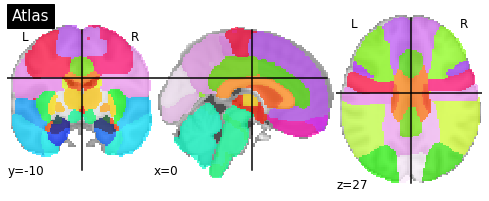

In [0]:
plotting.plot_roi('./atlas.nii', title="Atlas")
plotting.show()

load the data

In [0]:
dim=2 # dimension    
with np.load('./Data_ADNI.npz',allow_pickle=True) as data:
    X = data['X'] # features (average PET signals over ROIs)   
    y = data['y'] # classes    
    labelsChar = data['labels']    
    
N,M = X.shape # number of subjects and number of ROIs
class_names = ["control","alzheimer"] # y=0, y=1
print('Number of subjects', N,'; Number of features', M)
print('Number of controls and Alzheimer patients is respectively: {0} and {1}'.format(N-np.sum(y), np.sum(y)))


Number of subjects 60 ; Number of features 69
Number of controls and Alzheimer patients is respectively: 30 and 30
[['B' 'a' 'c' ... ' ' ' ' ' ']
 ['L' 'e' 'f' ... ' ' ' ' ' ']
 ['R' 'i' 'g' ... ' ' ' ' ' ']
 ...
 ['R' 'i' 'g' ... ' ' ' ' ' ']
 ['L' 'e' 'f' ... ' ' ' ' ' ']
 ['R' 'i' 'g' ... ' ' ' ' ' ']]


Labels are coded as series of characters, it is more convenient to transform them in strings. As you can see the ROIs are anatomical areas of the brain

In [0]:
labelsString = np.empty(M, dtype='object')
for i in range(M):
  roiName=''.join(labelsChar[i,:])
  labelsString[i]=roiName

print(labelsString)

['Background                            '
 'Left Hippocampus                      '
 'Right Hippocampus                     '
 'Left Amygdala                         '
 'Right Amygdala                        '
 'Left Anterior Medial Temporal Lobe    '
 'Right Anterior Medial Temporal Lobe   '
 'Left Anterior Lateral Temporal Lobe   '
 'Right Anterior Lateral Temporal Lobe  '
 'Left Ambient and Parahippocampus Gyri '
 'Right Ambient and Parahippocampus Gyri'
 'Left Superior Temporal Gyrus          '
 'Right Superior Temporal Gyrus         '
 'Left Inferior Middle Temporal Gyri    '
 'Right Inferior Middle Temporal Gyri   '
 'Left Fusiform Gyrus                   '
 'Right Fusiform Gyrus                  '
 'Left Cerebellum                       '
 'Right Cerebellum                      '
 'Left Brainstem                        '
 'Right Brainstem                       '
 'Left Insula                           '
 'Right Insula                          '
 'Left Lateral Occipital Lobe     

use method mentioned in previous toy classification project







In [0]:
# Shuffle data randomly
indeces=np.arange(N) # Integers from 0 to N-1
#print(indeces)

np.random.shuffle(indeces)
#print(indeces)

Xp=X[indeces]
Yp=y[indeces]
Xmean = np.mean(Xp,axis=0) # Compute average

labelsCharsp=[''] * N
for i in range(0,N):
    labelsCharsp[i]=labelsChar[indeces[i]]   



In [0]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(Xp, Yp, test_size=0.1, random_state=42)

Fitting LDA to training set
done in 0.016s
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.67      0.80         3

    accuracy                           0.83         6
   macro avg       0.88      0.83      0.83         6
weighted avg       0.88      0.83      0.83         6

Normalized confusion matrix
[[1.         0.        ]
 [0.33333333 0.66666667]]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


<Figure size 432x288 with 0 Axes>

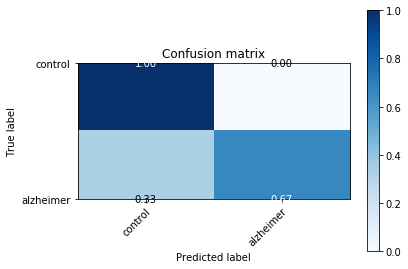

In [0]:
# Fitting LDA
t0 = time()
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
print("done in %0.2fs" % (time() - t0))
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)
plt.show()

In [0]:
# Cross-validation for Model Assessment

# Fitting LDA
print("Fitting LDA")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda_score = cross_val_score(lda,Xp, Yp,cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))

# Fitting QDA
print("Fitting QDA")
t0 = time()
qda = QuadraticDiscriminantAnalysis()
qda_score = cross_val_score(qda,Xp, Yp,cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(qda_score.mean(), qda_score.std() ))

# Fitting Logistic-regression
print("Fitting Logistic Regression")
t0 = time()
logit = LogisticRegression(solver='lbfgs')
logit_score = cross_val_score(logit,Xp, Yp,cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(logit_score.mean(), logit_score.std() ))

# Fitting Naive-Bayes
print("Fitting Naive-Bayes")
t0 = time()
GNB = GaussianNB()
GNB_score = cross_val_score(GNB,Xp, Yp,cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(GNB_score.mean(), GNB_score.std() ))

# Fitting K-nearest neighbour
print("Fitting K-nearest neighbour")
t0 = time()
neigh = KNeighborsClassifier(n_neighbors=3)
neigh_score = cross_val_score(neigh,Xp, Yp,cv=5)
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(neigh_score.mean(), neigh_score.std() ))

Fitting LDA
done in 0.025s
 Average and std CV score : 0.7333333333333333 +- 0.1224744871391589
Fitting QDA
done in 0.021s
 Average and std CV score : 0.5666666666666667 +- 0.11055415967851333
Fitting Logistic Regression
done in 0.068s
 Average and std CV score : 0.85 +- 0.06236095644623234
Fitting Naive-Bayes
done in 0.010s
 Average and std CV score : 0.85 +- 0.06236095644623234
Fitting K-nearest neighbour
done in 0.016s
 Average and std CV score : 0.8 +- 0.11303883305208778


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please

Conclusion:The best classification algorithm is the logistic regression.
